<a href="https://colab.research.google.com/github/soroushmirzaei/medical-biological-projects/blob/main/white-blood-cells-classification/white-blood-cells-classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#import requirements libraries
import os
import zipfile

#import mathematics statics libraries
import numpy as np
import pandas as pd

#import visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

#import machine learning deep learning libraries
import tensorflow as tf
from tensorflow import keras


In [ ]:
#make kaggle json file
kaggle_json = {
    "username":"kaggle-api-token-username",
    "key":"kaggle-api-token-key"
}
pd.Series(kaggle_json).to_json('kaggle.json')

#install kaggle libraries
!pip install -q kaggle

#setup kaggle libraries
!mkdir -p ~/.kaggle
!cp /content/kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json


In [ ]:
#download kaggle dataset
!kaggle datasets download paultimothymooney/blood-cells


 97% 105M/108M [00:05<00:00, 29.7MB/s] 
100% 108M/108M [00:05<00:00, 22.0MB/s]


In [ ]:
#unzip file
def unzip(file_name, type_file = 'zip'):
    cur_dir = os.getcwd()
    file_path = os.path.join(cur_dir, f'{file_name}.{type_file}')
    file = zipfile.ZipFile(file_path)
    file.extractall(os.path.join(cur_dir, file_name))
    file.close()


In [ ]:
unzip('blood-cells')


In [ ]:
#remove file with zero size
def remove_file_zero(dir_path):
    for root, dirs, files in os.walk(dir_path):
        for file in files:
            if os.path.getsize(os.path.join(root, file)) == 0:
                os.remove(os.path.join(root, file))


In [ ]:
remove_file_zero('/content/blood-cells/dataset2-master/dataset2-master/images')


In [ ]:
#romove other file type
def remove_type(dir_path):
    for root, dirs, files in os.walk(dir_path):
        for file in files:
            if file.split('.')[-1] not in ['jpg', 'jpeg', 'bmp', 'png', 'gif']:
                os.remove(os.path.join(root, file))


In [ ]:
remove_type('/content/blood-cells/dataset2-master/dataset2-master/images/TRAIN')
remove_type('/content/blood-cells/dataset2-master/dataset2-master/images/TEST')
remove_type('/content/blood-cells/dataset2-master/dataset2-master/images/TEST_SIMPLE')


In [ ]:
#rename file in label num format
def rename_file(dir_path):
    for label in os.listdir(dir_path):
        num = 0
        for file in os.scandir(os.path.join(dir_path, label)):
            file_name = file.name
            ext = file_name.split('.')[1]
            num = num + 1
            os.rename(file.path, os.path.join(dir_path, label, f'{label} {num}.{ext}'))


In [ ]:
rename_file('/content/blood-cells/dataset2-master/dataset2-master/images/TRAIN')
rename_file('/content/blood-cells/dataset2-master/dataset2-master/images/TEST')
rename_file('/content/blood-cells/dataset2-master/dataset2-master/images/TEST_SIMPLE')


In [ ]:
#capsfold file names
def caps_file(dir_path):
    for root, dirs, files in os.walk(dir_path):
        for dir in dirs:
            os.rename(os.path.join(root,dir), os.path.join(root,dir.title()))
    for root, dirs, files in os.walk(dir_path):
        for file in files:
            os.rename(os.path.join(root,file), os.path.join(root,file.title()))


In [ ]:
caps_file('/content/blood-cells/dataset2-master/dataset2-master/images/TRAIN')
caps_file('/content/blood-cells/dataset2-master/dataset2-master/images/TEST')
caps_file('/content/blood-cells/dataset2-master/dataset2-master/images/TEST_SIMPLE')


In [ ]:
#define training validation set
Height = 200
Width = 200

train_gen = keras.preprocessing.image.ImageDataGenerator(rescale = 1/255, rotation_range = 180, zoom_range = 0.2,
                                                         height_shift_range = 0.3, width_shift_range = 0.3,
                                                         vertical_flip = True, horizontal_flip = True)
train_data = train_gen.flow_from_directory('/content/blood-cells/dataset2-master/dataset2-master/images/TRAIN',
                                           target_size = (Height, Width), batch_size = 128,
                                           color_mode = 'rgb', class_mode = 'sparse', seed = 0)

valid_gen = keras.preprocessing.image.ImageDataGenerator(rescale = 1/255)
valid_data = valid_gen.flow_from_directory('/content/blood-cells/dataset2-master/dataset2-master/images/TEST',
                                         target_size = (Height, Width), batch_size = 128,
                                         color_mode = 'rgb', class_mode = 'sparse', seed = 0)

test_gen = keras.preprocessing.image.ImageDataGenerator(rescale = 1/255)
test_data = test_gen.flow_from_directory('/content/blood-cells/dataset2-master/dataset2-master/images/TEST_SIMPLE',
                                         target_size = (Height, Width), batch_size = 128,
                                         color_mode = 'rgb', class_mode = 'sparse', seed = 0)


Found 9957 images belonging to 4 classes.
Found 2487 images belonging to 4 classes.
Found 71 images belonging to 4 classes.


In [ ]:
#define pretrained model
pretrained_model = keras.applications.InceptionResNetV2(input_shape = (Height, Width, 3), include_top = False)

for layer in pretrained_model.layers:
    layer.trainable = True


In [ ]:
#create model function
def create_model(#dense layer configuration
                 dense_layers_num, dense_units, dense_dropout_ratio,
                 #output layer configuration
                 out_units = train_data.num_classes,
                 #activations configuration
                 dense_activation = 'relu', out_activation = 'softmax',

                 #input shape
                 inp_shape = (Height, Width, 3),

                 #compiling Configuration
                 compile_optimizer = 'adam', compile_loss ='sparse_categorical_crossentropy' ,
                 compile_metric = ['accuracy'],
                                  
                 #dense layers
                 dense_head = True,  batch_norm_dense = True, dropout_dense = True,
                 #output layer
                 dropout_out = True):

    #define input layer
    input = keras.Input(inp_shape)

    #define transfer learning layer
    out = pretrained_model(input)

    #convert dimensionality
    out = keras.layers.Flatten()(out)

    #feature extracter dropout layer 
    out = keras.layers.Dropout(0.3)(out)

    #define dense layers
    if dense_head:
        for i in range(dense_layers_num):
            if batch_norm_dense:
                out = keras.layers.BatchNormalization()(out)
            out = keras.layers.Dense(units = dense_units[i], activation = dense_activation)(out)
            if dropout_dense:
                out = keras.layers.Dropout(dense_dropout_ratio[i])(out)

    #define output layers
    output = keras.layers.Dense(units = out_units, activation = out_activation)(out)

    #define model with inputs and outputs
    model = keras.models.Model(input, output)

    #define model compile
    model.compile(optimizer = compile_optimizer,
                  loss = compile_loss,
                  metrics = compile_metric)

    return model


In [ ]:
#define custom callbacks
class callback(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs = None):
        self.model.save('/content/white-blood-cells-classification-model.h5')
        

In [ ]:
#create model
model = create_model(#dense layer configuration
                     dense_layers_num = 2, dense_units = [64, 64], dense_dropout_ratio = [0.3, 0.3], 
                     #output layer configuration
                     out_units = train_data.num_classes,
                     #activations configuration
                     dense_activation = 'relu', out_activation = 'softmax',
                     
                     #input shape
                     inp_shape = (Height, Width, 3),
                     
                     #compiling Configuration
                     compile_optimizer = 'adam', compile_loss = 'sparse_categorical_crossentropy' ,
                     compile_metric = ['accuracy'],

                     #dense layers
                     dense_head = True,  batch_norm_dense = True, dropout_dense = True,
                     #output layer
                     dropout_out = True)


In [ ]:
#fit model for training
model.fit(train_data, validation_data = valid_data, epochs = 100, verbose = 0,
          callbacks = [keras.callbacks.EarlyStopping(patience = 5, restore_best_weights = True, monitor = 'val_loss'),
                       keras.callbacks.CSVLogger('log.csv'), callback()])


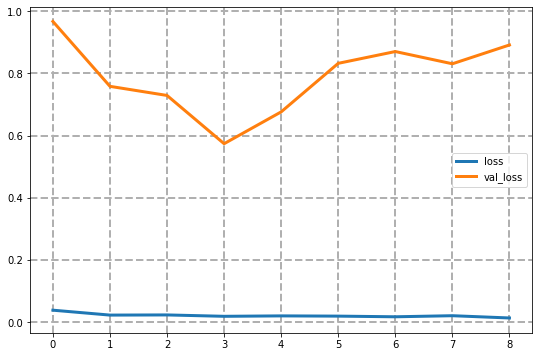

In [ ]:
#plot history and logger
pd.read_csv('/content/log.csv')[['loss', 'val_loss']].plot(figsize = (9, 6), linewidth = 3)
plt.grid(linestyle = '--', linewidth = 2)
plt.show()


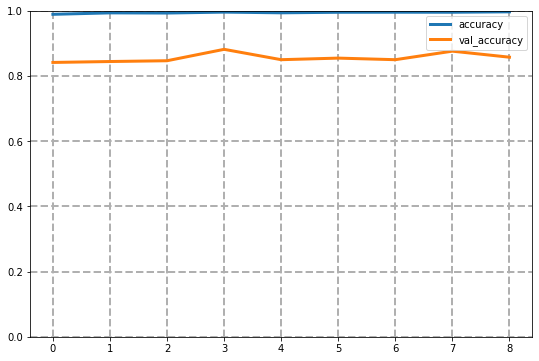

In [ ]:
#plot history and logger
pd.read_csv('/content/log.csv')[['accuracy', 'val_accuracy']].plot(figsize = (9, 6), linewidth = 3)
plt.grid(linestyle = '--', linewidth = 2)
plt.ylim(0,1)
plt.show()


In [ ]:
#model evaluation
train_set_eval = model.evaluate(train_data, verbose = 0, return_dict = True)
valid_set_eval = model.evaluate(valid_data, verbose = 0, return_dict = True)
test_set_eval = model.evaluate(test_data, verbose = 0, return_dict = True)

print('Training Set Evaluation:')
for item in train_set_eval:
    print(f'\t{item.title()}:\t{round(train_set_eval[item],4)}', end = '\t')
print()
print('Validation Set Evaluation:')
for item in valid_set_eval:
    print(f'\t{item.title()}:\t{round(valid_set_eval[item],4)}', end = '\t')
print()
print('Testing Set Evaluation:')
for item in valid_set_eval:
    print(f'\t{item.title()}:\t{round(test_set_eval[item],4)}', end = '\t')


Training Set Evaluation:
	Loss:	0.0217		Accuracy:	0.9931	
Validation Set Evaluation:
	Loss:	0.5737		Accuracy:	0.8814	
Testing Set Evaluation:
	Loss:	0.2536		Accuracy:	0.9437	

In [ ]:
#make list of images for random prediction
def image_file(dir_path):
    image_list = list()
    for root, dirs, files in os.walk(dir_path):
        for file in files:
            image_list.append(os.path.join(root, file))
    return image_list


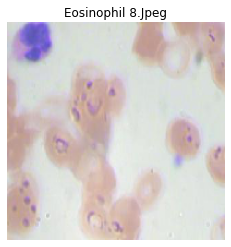

In [ ]:
#draw random image
img = np.random.choice(image_file('/content/blood-cells/dataset2-master/dataset2-master/images/TEST_SIMPLE'))
image = img
img = keras.preprocessing.image.load_img(img, target_size = (Height, Width),
                                         color_mode = 'rgb')
img = keras.preprocessing.image.img_to_array(img)

img = img/255
plt.axis('off')
plt.imshow(img)
plt.title(image.split('/')[-1])
plt.show()


In [ ]:
#prediction for random image
img = np.expand_dims(img, 0)
pd.DataFrame(model.predict(img), columns = train_data.class_indices)


,Eosinophil,Lymphocyte,Monocyte,Neutrophil
0,0.963561,0.000076,0.000003,0.03636


In [ ]:
#save model
model.save('/content/white-blood-cells-classification-model.h5')
